# NLP COMMENTS ASSIGNMENT

This work has been carried out by:


*   María Blanco González-Mohíno
*   Pablo Velasco Crespo
*   José Alberto Seco Sánchez-Camacho
*   Adrián Ruíz Esteban

# Data Load


In [4]:
import pandas as pd
import numpy as np
import io
from math import ceil
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [3]:
comments = pd.read_csv('comments_preprocessed.csv')
comments.head(6)

,Unnamed: 0,class,text,text_clean,text_no_contractions,text_lemmatized,text_without_repeated_words
0,0,Auto,I have recently purchased a J30T with moderat...,i have recently purchased a j30t with moderat...,i have recently purchased a j30t with moderat...,i have recently purchased a j30t with moderate...,self great well complaint quality after of rea...
1,1,Camera,I bought this product because I need instant ...,i bought this product because i need instant ...,i bought this product because i need instant ...,i bought this product because i need instant g...,density use computer want great cross contrast...
2,2,Auto,I have owned my Buick since 53000 km and I am...,i have owned my buick since 53000 km and i am...,i have owned my buick since 53000 km and i am...,i have owned my buick since 53000 km and i am ...,owned 2287 well great must but me driven of bu...
3,3,Camera,This was my first Digital camera so I did qui...,this was my first digital camera so i did qui...,this was my first digital camera so i did qui...,this wa my first digital camera so i did quite...,bummer great invest found quality but hope of ...
4,4,Camera,Minolta DiMAGE 7Hi is in a digital SLR with 5...,minolta dimage 7hi is in a digital slr with 5...,minolta dimage 7hi is in a digital slr with 5...,minolta dimage 7hi is in a digital slr with 5 ...,frame contrast useful area 7i me these after t...
5,5,Auto,I had a 1984 Saab a 1996 Saab and now a 1999...,i had a 1984 saab a 1996 saab and now a 1999...,i had a 1984 saab a 1996 saab and now a 1999...,i had a 1984 saab a 1996 saab and now a 1999 s...,saab ride beating me but school of tighter dur...


# Sentiment Analysis

In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [29]:
def sent_analyzer(sent):
  sentiment = sentiment_analyzer.polarity_scores(sent) 
  return sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']

In [31]:
sentiment_analyzer  = SentimentIntensityAnalyzer() 
sentences = comments['text_without_repeated_words'].tolist()
sent = []

for i in sentences:
  neg, pos, neu, compound = sent_analyzer(i)
  sent.append([neg, pos, neu, compound])

df = pd.DataFrame(sent, columns=['neg', 'pos', 'neu', 'compound'])

In [32]:
df

,neg,pos,neu,compound
0,0.065,0.177,0.758,0.9490
1,0.064,0.186,0.751,0.9859
2,0.031,0.192,0.777,0.9817
3,0.152,0.207,0.640,0.8456
4,0.055,0.174,0.771,0.9960
...,...,...,...,...
595,0.064,0.176,0.761,0.9798
596,0.100,0.250,0.650,0.9853
597,0.072,0.340,0.589,0.9892
598,0.056,0.202,0.742,0.9902


The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
positive sentiment : (compound score >= 0.05) 
neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
negative sentiment : (compound score <= -0.05) (Esto esta sacado de internet)

Una cosa para hacer cuando este trabajo acabe es ver la media de todos los comentarios, es decir, ver si son mas negativos que positivos etc. # TODO

Overviewing one of the sentences that we analyzed

area ski after if i now 3 myself nail line mileage try by bookcase took dash same over dual ve 000 slipping in there aggressive this haul coming degree are seat suv like you heat gone to so window book with motor call them virgin awd ac middle completely feb design add chart 2 they m fly general where suggest time love 4x2 did rainer influence really hidden ha charging covering no a later haven full soon port 80 buick down thanks tiny trailblazer own white pick horsepower tim compartment do containing corner running family wet 4x4 hump monitarily t drive wiper sitting above felt handy 90 pontiac issue sweat possible entry pretty plenty must box but outside of buying being thanksgiving bump 70 rebate huge holding sliding blazer definetly 99 it splurged escape flip driver getting can roomie offer up unlock expect control we price every were amount strap told door deep any bumpin saw gm luckily decent speaker only an come radio version thing limited for large liberty having lack somehow s

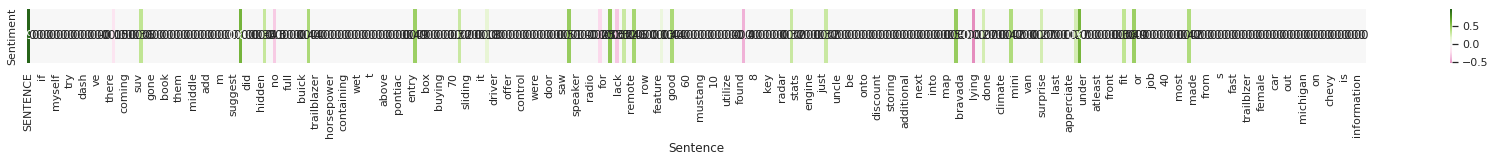

In [35]:
sns.set(rc={'figure.figsize':(30,1)})
def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

print(sentences[20])
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentences[20].split(),
    "Sentiment":[sentiment_analyzer.polarity_scores(sentences[20])["compound"]] + [sentiment_analyzer.polarity_scores(word)["compound"] for word in sentences[20].split()]
})

# Feature Selection

 # TODO

In [ ]:

# Create feature and target variable for Classification problem
X_clf=comments.iloc[:,1:] # features: from 1 to last

y_clf=comments.iloc[:,1] # Target variable: last one

print(X_clf.columns)
print(y_clf)

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camara', 1, y_clf)


print(y_clf)

size = len(X_clf.columns)
# Devuelve: El menor número entero no menor que x
to_cut = ceil(0.7*len(X_clf.columns))
to_save = size - to_cut

# k is the number of features you want to select [here it's 2]
X_clf_new=SelectKBest(score_func=chi2,k=to_save).fit_transform(X_clf,y_clf)

# Check the newly created variable for top two best features
#print(X_clf_new[:7])

# Classification 